# Ryder Classification Models

using the predictive maintainance dataset from kaggle:

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score,fbeta_score, average_precision_score, recall_score, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import LeavePOut, StratifiedKFold, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [2]:
data = pd.read_csv("predictive_maintenance.csv")

In [3]:
data.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Product Types: Low Medium and High quality

In [38]:
data["Type"].unique()

array(['M', 'L', 'H'], dtype=object)

### Drop No failures coded as Failures and Drop Random Failures coded as no failures

In [39]:
print(data.shape)
# indexdelete = data[data['Failure Type'] == 'Random Failures'].index
# data.drop(indexdelete, inplace = True)
print(data.shape)
# indexdelete = data[(data['Failure Type'] == 'No Failure') & (data['Target'] == 1)].index
# data.drop(indexdelete, inplace = True)
data.shape

(10000, 10)
(10000, 10)


(10000, 10)

In [4]:
y = data[["Target", "Failure Type"]]
y_target = y["Target"]
#y_target.head(5)

### Nominal "tool type" to one-hot encoding

In [5]:
#Drop unecessary columns
X = data.drop(['UDI',"Target", "Failure Type", "Product ID", "Type"], axis=1)
#data.loc[:, ~data.columns.isin(["Target", "Failure Type", "Product ID", "Type"])]

#Convert Type to OHE columns
type = data["Type"]
onehottype= pd.get_dummies(type)
#print(onehottype.head(5))
X = pd.concat([X,onehottype], axis=1)
#X.head(5)


# #Scale the numerical data
numerical_data = X[X.select_dtypes(include='number').columns].astype(float)
numerical_data.info()

mms = MinMaxScaler()

# fitting the minmax processing and accomodating it to the dataframe
X = pd.DataFrame(mms.fit_transform(numerical_data))
X.set_axis(['Air Temp', 'Process Temp', 'Rotation speed', 'Torque','Tool wear','H','L','M'], axis=1, inplace=True)
X.describe()
#X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   H                        10000 non-null  float64
 6   L                        10000 non-null  float64
 7   M                        10000 non-null  float64
dtypes: float64(8)
memory usage: 625.1 KB


,Air Temp,Process Temp,Rotation speed,Torque,Tool wear,H,L,M
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.511405,0.531551,0.215818,0.497073,0.426684,0.100300,0.600000,0.299700
std,0.217419,0.183177,0.104356,0.136936,0.251597,0.300415,0.489922,0.458149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.326087,0.382716,0.148428,0.403846,0.209486,0.000000,0.000000,0.000000
50%,0.521739,0.543210,0.194994,0.498626,0.426877,0.000000,1.000000,0.000000
75%,0.673913,0.666667,0.258440,0.590659,0.640316,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y_target,train_size = 0.8, random_state = 69)
print(X_test.shape, y_test.shape)

(2000, 8) (2000,)


## First Try KNN Model - Not Great! ##

In [43]:
model = KNeighborsClassifier(2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

print('f1 = ',f1_score(y_test,y_pred), "Precision = ", average_precision_score(y_test,y_pred), balanced_accuracy_score(y_test,y_pred))
print('ROC AUC = ', roc_auc_score(y_test,y_pred))
tp,fn,fp


[[1940    4]
 [  45   11]]
f1 =  0.30985915492957744 Precision =  0.16654761904761903 0.5971854791299236
ROC AUC =  0.5971854791299236


C:\Users\alexhu\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


(11, 45, 4)

# Random Forest - Works better #

In [44]:
model = RandomForestClassifier(n_estimators=25,random_state=69)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print('weighted f1 = ', fbeta_score(y_test,y_pred,beta=1), ", Precision = ", average_precision_score(y_test,y_pred), ", Balanced Accuracy (ROC AUC) = ", balanced_accuracy_score(y_test,y_pred))
print('ROC AUC = ', roc_auc_score(y_test,y_pred))
tp,fn,fp

[[1939    5]
 [  25   31]]
weighted f1 =  0.6739130434782609 , Precision =  0.489186507936508 , Balanced Accuracy (ROC AUC) =  0.7754997060552616
ROC AUC =  0.7754997060552616


(31, 25, 5)

Cross Validating RF

In [45]:
kf = StratifiedKFold(5)
scores = cross_val_score(model,X,y_target,scoring="f1", cv = kf)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.49484536 0.41584158 0.09700722 0.36363636 0.61386139]
Average CV Score:  0.39703838374006883
Number of CV Scores used in Average:  5


# Try XGBoost


In [46]:
xgb_model = xgb.XGBRFClassifier(n_estimators = 100, max_depth = 9, min_child_weight = 1, eta = 1, objective = "binary:hinge", eval_metric = 'error', random_state=69)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print('weighted f1 = ', fbeta_score(y_test,y_pred,beta=1), ", Precision = ", average_precision_score(y_test,y_pred), ", Balanced Accuracy (ROC AUC) = ", balanced_accuracy_score(y_test,y_pred))
print('ROC AUC = ', roc_auc_score(y_test,y_pred))
print(tp,fn,fp)
kf = StratifiedKFold(n_splits = 5)
scores = cross_val_score(xgb_model,X,y_target,scoring="f1", cv = kf)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

[[1918   26]
 [  16   40]]
weighted f1 =  0.6557377049180327 , Precision =  0.4409004329004329 , Balanced Accuracy (ROC AUC) =  0.8504556143445032
ROC AUC =  0.8504556143445033
40 16 26
Cross Validation Scores:  [0.60465116 0.58992806 0.11665099 0.54545455 0.7768595 ]
Average CV Score:  0.5267088515403785
Number of CV Scores used in Average:  5


# Ultimately XGBoost worked best - pretty decent

And with Stratified Cross Validation XGBoost comes out on top with a much better Avg F1

As a comparison here is a simple baseline algo that just guesses that there are no failures

In [28]:
y_baseline = np.zeros(len(y_test))

print(confusion_matrix(y_test,y_baseline))
tn, fp, fn, tp = confusion_matrix(y_test,y_baseline).ravel()
print('weighted f1 = ', fbeta_score(y_test,y_baseline,beta=1), ", Precision = ", average_precision_score(y_test,y_baseline), ", Actual Accuracy = ", accuracy_score(y_test,y_baseline))
print('ROC AUC = ', roc_auc_score(y_test,y_baseline))
tp,fn,fp

[[1944    0]
 [  56    0]]
weighted f1 =  0.0 , Precision =  0.028 , Actual Accuracy =  0.972
ROC AUC =  0.5


(0, 56, 0)

# SVM absolutely fails

I need to tweak the settings

In [48]:
# model = SVC()
# model.fit(X_train, y_train)
# print('training accuracy (kinda useless metric)= ', model.score(X_train, y_train))
# y_pred = model.predict(X_test)


# print(confusion_matrix(y_test,y_pred))
# tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
# print('weighted f1 = ', fbeta_score(y_test,y_pred,beta=1), ", Precision = ", average_precision_score(y_test,y_pred), ", Balanced Accuracy (ROC AUC) = ", balanced_accuracy_score(y_test,y_pred))
# print('ROC AUC = ', roc_auc_score(y_test,y_pred))
# tp,fn,fp

# Reduced dimensions

Already dropped ID, No Need to drop anymore features

In [31]:
print(X.head())
X_reduced = X #.drop(['Process Temp'], axis=1) #, "Air Temp", 'Process Temp'
print(X_reduced.head())
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_reduced,y_target,train_size = 0.8, random_state = 69)
print(X_testr.shape, y_testr.shape)

   Air Temp  Process Temp  Rotation speed    Torque  Tool wear    H    L    M
0  0.304348      0.358025        0.222934  0.535714   0.000000  0.0  0.0  1.0
1  0.315217      0.370370        0.139697  0.583791   0.011858  0.0  1.0  0.0
2  0.304348      0.345679        0.192084  0.626374   0.019763  0.0  1.0  0.0
3  0.315217      0.358025        0.154249  0.490385   0.027668  0.0  1.0  0.0
4  0.315217      0.370370        0.139697  0.497253   0.035573  0.0  1.0  0.0
   Air Temp  Process Temp  Rotation speed    Torque  Tool wear    H    L    M
0  0.304348      0.358025        0.222934  0.535714   0.000000  0.0  0.0  1.0
1  0.315217      0.370370        0.139697  0.583791   0.011858  0.0  1.0  0.0
2  0.304348      0.345679        0.192084  0.626374   0.019763  0.0  1.0  0.0
3  0.315217      0.358025        0.154249  0.490385   0.027668  0.0  1.0  0.0
4  0.315217      0.370370        0.139697  0.497253   0.035573  0.0  1.0  0.0
(2000, 8) (2000,)


In [50]:
# model = RandomForestClassifier(n_estimators=100,random_state=69)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print(confusion_matrix(y_test,y_pred))
# tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
# print('weighted f1 = ', fbeta_score(y_test,y_pred,beta=2), ", Precision = ", average_precision_score(y_test,y_pred), ", Balanced Accuracy (ROC AUC) = ", balanced_accuracy_score(y_test,y_pred))
# print('ROC AUC = ', roc_auc_score(y_test,y_pred))
# tp,fn,fp

# kf = StratifiedKFold(5)
# scores = cross_val_score(model,X_reduced,y_target,scoring="f1", cv = kf)
# print("Cross Validation Scores: ", scores)
# print("Average CV Score: ", scores.mean())

In [25]:
xgb_model = xgb.XGBRFClassifier(
    objective= 'binary:hinge',
    nthread=4,
    seed=69
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 100, 20),
    #'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight' : [1,5,10]
}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_trainr, y_trainr)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=None,
                                       gpu_id=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       m...
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None, nthread=4,
                           

In [26]:
#Print the params of the winner
for key, value in enumerate(clf.cv_results_['rank_test_score']):
    if 1 == value:
        print(clf.cv_results_['params'][key])

{'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 60}


In [30]:
xgb_model = xgb.XGBRFClassifier(n_estimators = 60, max_depth = 7, min_child_weight = 60, objective = "binary:hinge", random_state=69)
xgb_model.fit(X_trainr, y_trainr)
y_pred = xgb_model.predict(X_testr)

print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print('weighted f1 = ', fbeta_score(y_test,y_pred,beta=2), ", Precision = ", average_precision_score(y_test,y_pred), ", Balanced Accuracy (ROC AUC) = ", balanced_accuracy_score(y_test,y_pred))
print('ROC AUC = ', roc_auc_score(y_test,y_pred))
print (tp,fn,fp, fn+fp)

kf = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(xgb_model,X_reduced,y_target,scoring="f1", cv = kf)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())

[[1879   65]
 [  17   39]]
weighted f1 =  0.5945121951219513 , Precision =  0.2696607142857143 , Balanced Accuracy (ROC AUC) =  0.831496178718401
ROC AUC =  0.8314961787184009
39 17 65 82
Cross Validation Scores:  [0.56969697 0.51648352 0.61202186 0.60540541 0.53409091]
Average CV Score:  0.5675397317200596


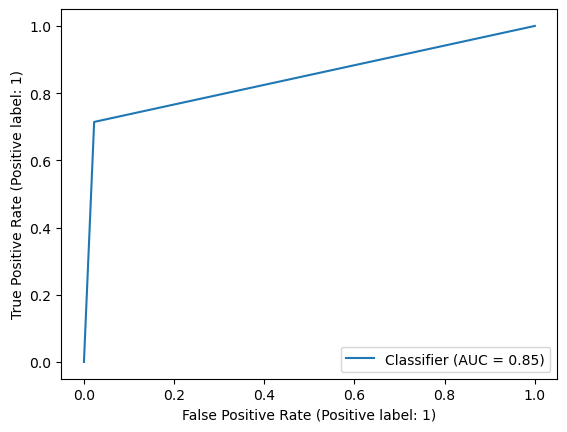

In [52]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred)

# Original Features Importance

Note H, L and M are one hot encoded from tool type

Feature: Air Temp, Score: 0.12887
Feature: Process Temp, Score: 0.11098
Feature: Rotation speed, Score: 0.24796
Feature: Torque, Score: 0.33744
Feature: Tool wear, Score: 0.15375
Feature: H, Score: 0.00521
Feature: L, Score: 0.00877
Feature: M, Score: 0.00702


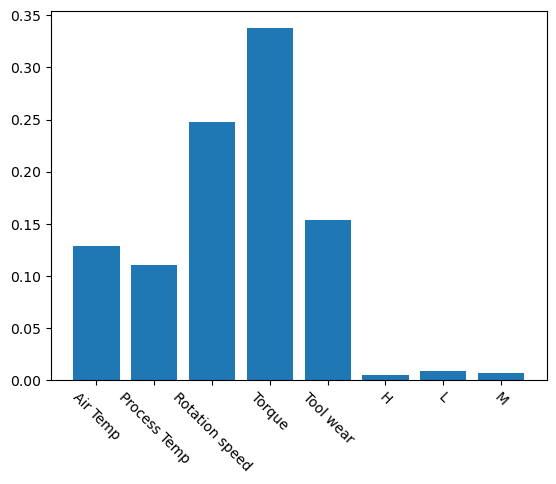

In [53]:
from matplotlib import pyplot
headerlist = X.columns.tolist()
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (headerlist[i],v))
# plot feature importance
pyplot.bar([headerlist[x] for x in range(len(importance))], importance)
pyplot.xticks(rotation=-45)
pyplot.show()

# Reduced dimensions

Lets see the feature importance here

Feature: Air Temp, Score: 0.14827
Feature: Rotation speed, Score: 0.13336
Feature: Torque, Score: 0.29346
Feature: Tool wear, Score: 0.15868
Feature: H, Score: 0.06324
Feature: L, Score: 0.12880
Feature: M, Score: 0.07419


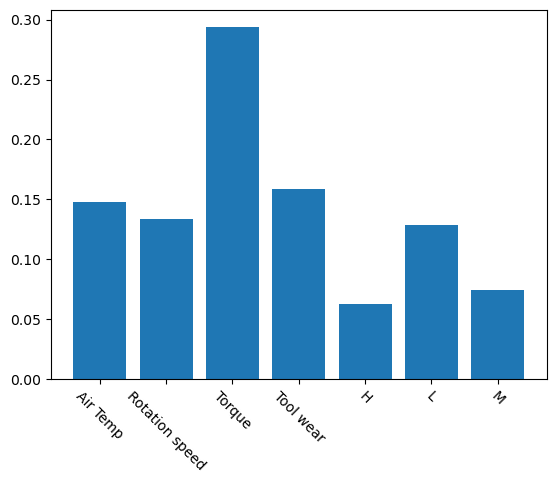

In [54]:
from matplotlib import pyplot
headerlist = X_train.columns.tolist()
# get importance
importance = xgb_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (headerlist[i],v))
# plot feature importance
pyplot.bar([headerlist[x] for x in range(len(importance))], importance)
pyplot.xticks(rotation=-45)
pyplot.show()
